## import library

In [8]:
import os
import gc
import joblib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from argparse import Namespace
from collections import defaultdict


import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, train_test_split

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer



import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 64)

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [19]:
args = Namespace(
    INFER=True,
    debug=False,
    seed=21,
    folds=5,
    workers=4,
    min_time_id=None, 
    holdout=True,
    num_bins=16,
    data_path=Path("../input/ubiquant-market-prediction-half-precision-pickle"),
    dnn_path = '../input/dnnmodel',
    tabnet_path = '../input/ubiquanttabnetbaseline'
)
seed_everything(args.seed)

if args.debug:
    setattr(args, 'min_time_id', 1100)

## Import dataset

In [20]:
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle(r"C:\Users\lab\Desktop\ubiquant-market-prediction\train.pkl")
train.head()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,...,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.0,1.0,-0.300781,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,0.004936,0.284220,0.502155,-0.287932,-1.169338,-0.267310,-0.574423,-0.771869,1.012212,-1.230507,1.785726,-2.090686,0.325659,-0.877769,1.048786,0.131774,-0.349609,-1.813385,0.099226,...,0.900593,-0.924766,-1.057890,-0.167062,0.0,1.281245,0.258715,-0.237964,-0.742125,-0.324677,0.992547,0.961355,-0.025610,-0.006259,0.473603,0.040136,0.453711,-1.597790,0.301659,0.157470,0.416631,1.506131,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.0,2.0,-0.231079,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,-0.351726,0.846882,0.440299,0.499824,0.893144,-0.010217,-0.681523,1.254092,-1.026969,-1.690156,0.011152,0.875251,0.325659,-0.458305,-1.797581,-0.300364,0.584786,0.551460,0.806422,...,0.171233,1.165891,0.590802,0.118520,0.0,-0.650803,0.851905,0.086198,1.135668,0.298990,-1.583445,-0.481945,0.532229,0.226693,-0.894744,-0.514552,-1.000073,0.884377,-0.557502,-0.875265,-0.156106,0.537055,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.0,6.0,0.568848,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,0.465096,0.150847,-0.044009,0.091257,-1.169338,-0.451820,-0.467322,0.095288,1.140719,-0.166894,-0.007295,-0.449418,0.325659,-0.682472,0.016262,0.026124,-0.547330,0.551460,-0.261588,...,-0.161757,-0.114321,0.433277,-0.207127,0.0,0.098910,-0.725177,-0.388189,0.062644,0.260281,0.980960,0.899393,-0.315315,0.150139,0.245546,-1.429645,-1.000073,-0.033494,-0.147156,-0.087518,0.098443,-0.529027,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0.0,7.0,-1.064453,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,0.301204,-0.015678,-0.656295,-0.150829,-1.169338,-1.121598,-0.681523,2.921973,1.179453,0.363938,0.365656,-1.478154,0.325659,0.955586,-0.105029,-0.588826,0.650101,-1.813385,-1.421967,...,-1.024947,-0.924766,1.013206,-0.324558,0.0,-0.817650,-0.624180,0.012915,0.599156,-1.796107,-1.843759,2.927223,-0.640443,2.324936,-0.666686,-0.049966,-1.000073,-0.172537,-0.557502,-0.986692,-0.744752,0.237733,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.0,8.0,-0.531738,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,0.498780,-0.235516,-0.173336,0.106523,-0.138097,-0.829021,-0.826026,4.070158,0.148330,0.269455,-0.046685,0.194325,0.325659,1.933630,-1.119676,-0.585332,0.535749,0.551460,-0.771058,...,-1.508002,1.165891,0.941384,-0.501547,0.0,-1.332959,-0.767390,-0.237964,0.330900,-1.465071,-0.585437,-1.314835,-0.781270,-1.918721,-0.438628,-1.576060,-1.226833,1.067312,-0.519032,-1.221407,-0.768617,-0.723919,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [21]:
investment_id = train['investment_id']
investment_id.head()

y = train['target']
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

## custom loss function (ccc)

In [22]:
def custom_loss(pred_y, true_y):
    pred_mean = tf.math.reduced_mean(pred_y)
    true_mean = tf.math.reduced_mean(true_y)

    pred_std = tf.math.reduced_std(pred_y)
    true_std = tf.math.reduced_std(true_y)

    corr_ = tf.math.reduced_sum((pred_y-pred_mean)*(true_y-true_mean))/(len(pred_y)-1)
    ccc = (2*corr_*pred_std*true_std)/(pred_std**2+true_std**2+(pred_mean-true_mean)**2)

    mse = tf.math.reduce_sum((pred_y-true_y)**2)/tf.cast((len(pred_y)-1),tf.float32)
    return 1- ccc + mse

## Create a IntegerLookup layer for investment_id input

In [23]:
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
print(investment_id_size)
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
## integerlookup은 
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids})) 
## 일부 전처리 레이어는 훈련데이터의 셈플을 기반으로 계산해야하는 내부 상태가 있음.
## 이러한 전처리 레이어는 '훈련불가능'하기 때문에 훈련중 설정이 되지않음. -> 훈련전에 설정해야함
## 이 단계를 적응(adaptation)이라고 함.


2789


In [14]:
import tensorflow as tf

def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096) ## 완벽한 셔플링을 위해서는 셔플링의 크기와 버퍼의 크기가 같아야함
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    ## Embedding()을 사용하기 위해서는 입력 될 각 단어들은 모두 정수 인덱싱이 되어 있어야 합니다.
    # this code uses variables embedding method because one-hot encoding has many computational costs 

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1,embeddings_initializer="glorot_uniform")(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)

    investment_id_x = layers.Dense(64,kernel_initializer = "glorot_uniform")(investment_id_x)
    investment_id_x = layers.BatchNormalization(64)(investment_id_x)
    investment_id_x = layers.Activation('swish')(investment_id_x)

    investment_id_x = layers.Dense(64,kernel_initializer = "glorot_uniform")(investment_id_x)
    investment_id_x = layers.BatchNormalization(64)(investment_id_x)
    investment_id_x = layers.Activation('swish')(investment_id_x)

    investment_id_x = layers.Dense(64,kernel_initializer = "glorot_uniform")(investment_id_x)
    investment_id_x = layers.BatchNormalization(64)(investment_id_x)
    investment_id_x = layers.Activation('swish')(investment_id_x)


    feature_x = layers.Dense(256,kernel_initializer = "glorot_uniform")(features_inputs)
    feature_x = layers.BatchNormalization(256)(feature_x)
    feature_x = layers.Activation('swish')(feature_x)

    feature_x = layers.Dense(256,kernel_initializer = "glorot_uniform")(feature_x)
    feature_x = layers.BatchNormalization(256)(feature_x)
    feature_x = layers.Activation('swish')(feature_x)

    feature_x = layers.Dense(256,kernel_initializer = "glorot_uniform")(feature_x)
    feature_x = layers.BatchNormalization(256)(feature_x)
    feature_x = layers.Activation('swish')(feature_x)


    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])

    x = layers.Dense(512,kernel_initializer = "glorot_uniform", kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(512)(x)
    x = layers.Activation('swish')(x)

    x = layers.Dense(128,kernel_initializer = "glorot_uniform", kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(128)(x)
    x = layers.Activation('swish')(x)

    x = layers.Dense(32,kernel_initializer = "glorot_uniform", kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(32)(x)
    x = layers.Activation('swish')(x)
    
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss=custom_loss, metrics=['mse', "mae", "mape", rmse, custom_loss])
    return model

In [24]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['input_17[0][0]']               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 32)        89248       ['integer_lookup[7][0]']         
                                                                                                  
 reshape_7 (Reshape)            (None, 32)           0           ['embedding_7[0][0]']            
                                                                                            

In [29]:
%%time
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models_dnn = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    #if args.INFER == False:
    X_train, X_val = train[features].iloc[train_indices], train[features].iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    if args.INFER == False:
        train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"{args.dnn_path}/model_{index}.tf", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    if args.INFER == False:
        history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model.load_weights(f"{args.dnn_path}/model_{index}.tf")
    models_dnn.append(model)
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    if args.INFER == False:
        pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
        plt.title("MSE")
        plt.show()
        pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
        plt.title("MAE")
        plt.show()
        pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
        plt.title("RMSE")
        plt.show()
        
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    if args.INFER == False:
        del train_ds
    del valid_ds
    gc.collect()
    break

C:\Users\USER\Anaconda3\envs\tw_tf\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


X_train : 	               f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0        0.932573  0.113691 -0.402206  0.378386 -0.203938 -0.413469  0.965623   
1        0.810802 -0.514115  0.742368 -0.616673 -0.194255  1.771210  1.428127   
2        0.393974  0.615937  0.567806 -0.607963  0.068883 -1.083155  0.979656   
3       -2.343535 -0.011870  1.874606 -0.606346 -0.586827 -0.815737  0.778096   
6       -1.863797  0.113691  1.573864 -0.598433 -0.569936  0.398784  0.054528   
...           ...       ...       ...       ...       ...       ...       ...   
3141404  0.892171 -1.760851  0.135189 -0.405799 -0.214687  0.142001  1.134768   
3141405  0.093530 -0.720275 -0.345497 -0.438781 -0.166972 -0.437182  1.475746   
3141406 -1.344935 -0.199987 -0.107702 -0.454677 -0.221914 -0.141174 -1.498235   
3141408 -2.565332  0.320301  0.076600  1.380182 -0.155366 -0.689000  0.381069   
3141409 -0.089557  0.190229 -0.548256  0.151205  0.079773  0.447962  1.014983   

              f

### Create Time ID DF

In [31]:
time_id_df = (
    train.filter(regex=r"^(?!f_).*")
    .groupby("investment_id")
    .agg({"time_id": ["min", "max"]})
    .reset_index()
)
time_id_df["time_span"] = time_id_df["time_id"].diff(axis=1)["max"]
time_id_df.head(6)

investment_id time_id         time_span
                    min     max          
0           0.0   757.0  1219.0     462.0
1           1.0     0.0  1219.0    1219.0
2           2.0     0.0  1219.0    1219.0
3           3.0    24.0  1219.0    1195.0
4           4.0   885.0  1219.0     334.0
5           6.0     0.0  1219.0    1219.0

In [32]:
print(time_id_df.drop(columns="time_id"))
print(time_id_df.drop(columns="time_id").droplevel(level=1, axis=1))

     investment_id time_span
                            
0              0.0     462.0
1              1.0    1219.0
2              2.0    1219.0
3              3.0    1195.0
4              4.0     334.0
...            ...       ...
2783        3764.0    1219.0
2784        3766.0    1219.0
2785        3768.0    1219.0
2786        3770.0    1219.0
2787        3772.0    1219.0

[2788 rows x 2 columns]
      investment_id  time_span
0               0.0      462.0
1               1.0     1219.0
2               2.0     1219.0
3               3.0     1195.0
4               4.0      334.0
...             ...        ...
2783         3764.0     1219.0
2784         3766.0     1219.0
2785         3768.0     1219.0
2786         3770.0     1219.0
2787         3772.0     1219.0

[2788 rows x 2 columns]


### Merge Time ID DF

1804

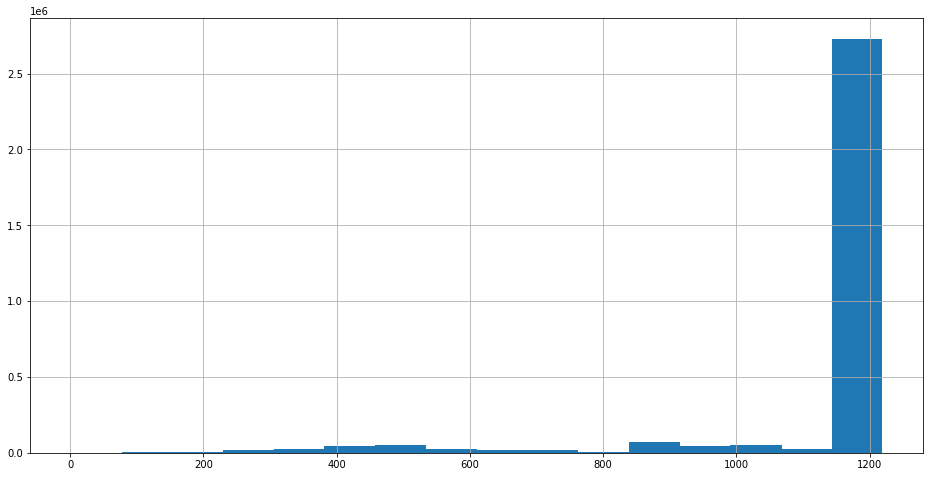

In [25]:
train = train.merge(time_id_df.drop(columns="time_id").droplevel(level=1, axis=1), on="investment_id")
## drop level은 time id 지우고 나서 한 칸 남아서 남은칸 삭제
train.time_span.hist(bins=args.num_bins, figsize=(16,8))
del time_id_df
gc.collect()

In [ ]:
train["fold"] = -1
_target = pd.cut(train.time_span, args.num_bins, labels=False)
skf = StratifiedKFold(n_splits=args.folds)
for fold, (train_index, valid_index) in enumerate(skf.split(_target, _target)):
    train.loc[valid_index, 'fold'] = fold
    
fig, axs = plt.subplots(nrows=args.folds, ncols=1, sharex=True, figsize=(16,8), tight_layout=True)
for ax, (fold, df) in zip(axs, train[["fold", "time_span"]].groupby("fold")):
    ax.hist(df.time_span, bins=args.num_bins)
    ax.text(0, 40000, f"fold: {fold}, count: {len(df)}", fontsize=16)
plt.show()
del _target, train_index, valid_index
_=gc.collect()

In [ ]:
X = train.drop(['target', 'time_id'], axis = 1)
y = train['target']

In [ ]:
num_features = [f"f_{i}" for i in range(300)]
cat_features = ["investment_id"]
features = num_features + cat_features
features += ["time_id"]

## TabNet

#### Train Model


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return mean_squared_error(y_true,y_pred, squared=False)
def rmspe(y_true, y_pred):
    # Function to calculate the root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))
    

def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()



cat_idxs = [ i for i, f in enumerate(X.columns.tolist()) if f in cat_features]


def run():    
    tabnet_params = dict(
        cat_idxs=cat_idxs,
        cat_emb_dim=1,
        n_d = 16,
        n_a = 16,
        n_steps = 2,
        gamma =1.4690246460970766,
        n_independent = 9,
        n_shared = 4,
        lambda_sparse = 0,
        optimizer_fn = Adam,
        optimizer_params = dict(lr = (0.024907164557092944)),
        mask_type = "entmax",
        scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
        scheduler_fn = CosineAnnealingWarmRestarts,
        seed = 42,
        verbose = 10, 
    )    
    y = train['target']
    train['preds'] = -1000
    scores = defaultdict(list)
    features_importance= pd.DataFrame()
    
    for fold in range(args.folds):
        print(f"=====================fold: {fold}=====================")
        trn_ind, val_ind = train.fold!=fold, train.fold==fold
        print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
        X_train=train.loc[trn_ind, features].values
        y_train=y.loc[trn_ind].values.reshape(-1,1)
        X_val=train.loc[val_ind, features].values
        y_val=y.loc[val_ind].values.reshape(-1,1)

        clf =  TabNetRegressor(**tabnet_params)
        clf.fit(
          X_train, y_train,
          eval_set=[(X_val, y_val)],
          max_epochs = 355,
          patience = 50,
          batch_size = 1024*20, 
          virtual_batch_size = 128*20,
          num_workers = 4,
          drop_last = False,

          )
        
        clf.save_model(f'TabNet_seed{args.seed}_{fold}')


        preds = clf.predict(train.loc[val_ind, features].values)
        train.loc[val_ind, "preds"] = preds
        
        scores["rmse"].append(rmse(y.loc[val_ind], preds))
     
        del X_train,X_val,y_train,y_val
        gc.collect()
        
        
    print(f"TabNet {args.folds} folds mean rmse: {np.mean(scores['rmse'])}")
    train.filter(regex=r"^(?!f_).*").to_csv("preds.csv", index=False)
 #   return features_importance
if args.INFER:
    pass
else:
    run()  
#del df, train
gc.collect()

In [ ]:
import os
import zipfile
 
def zipDir(dirpath, outFullName):

    zip = zipfile.ZipFile(outFullName, "w", zipfile.ZIP_DEFLATED)
    for path, dirnames, filenames in os.walk(dirpath):

        fpath = path.replace(dirpath, '')

        for filename in filenames:
            zip.write(os.path.join(path, filename), os.path.join(fpath, filename))
    zip.close()
    

if args.INFER:
    for fold in range(5):
        input_path =f'{args.tabnet_path}/fold{fold}'
        output_path = f"./fold{fold}.zip"
        zipDir(input_path, output_path)
else:
    input_path =f'./TabNet_seed{args.seed}_{fold}'
    output_path = f"./fold{fold}.zip"

    zipDir(input_path, output_path)
tabnet_params = dict(
        cat_idxs=cat_idxs,
        cat_emb_dim=1,
        n_d = 16,
        n_a = 16,
        n_steps = 2,
        gamma =1.4690246460970766,
        n_independent = 9,
        n_shared = 4,
        lambda_sparse = 0,
        optimizer_fn = Adam,
        optimizer_params = dict(lr = (0.024907164557092944)),
        mask_type = "entmax",
        scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
        scheduler_fn = CosineAnnealingWarmRestarts,
        seed = 42,
        verbose = 10, 
    )    



import copy
clf =  TabNetRegressor(**tabnet_params)
models_tabnet = []
for fold in range(args.folds):
    clf.load_model(f"fold{fold}.zip")
    model=copy.deepcopy(clf)
    models_tabnet.append(model)

#### Prepare Test Inference

In [ ]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def make_test_dataset_lgbm(test_df,folds=5):
    features = [f"f_{i}" for i in range(300)]
    test_df[features] = scaler.fit_transform(test_df[features]) 
    clu = [kmodels[fold].predict(test_df[features]) for fold in range(folds)]
    test_df_l = [test_df for fold in range(folds)]
    for f in range(folds):
        test_df_l[f]['cluster'] = clu[f]
    return test_df_l

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

def inference_lgbm(models,ds,folds=5):
    features = [f"f_{i}" for i in range(300)]
    features_1 = features + ['cluster']
    final_pred = [models[fold].predict(ds[fold][features_1]) for fold in range(folds)]
    return np.mean(np.stack(final_pred), axis=0)

def inference_tabnet(models,test_df,args):
    num_features = [f"f_{i}" for i in range(300)]
    cat_features = ["investment_id"]
    features = num_features + cat_features
    features += ["time_id"]
    test_df["time_id"] = test_df.row_id.str.extract(r"(\d+)_.*").astype(np.uint16) # extract time_id form row_id
    final_pred = [models[fold].predict(test_df[features].values) for fold in range(args.folds)]
    return np.mean(np.stack(final_pred), axis=0)

## submission

In [ ]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

: 

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:

    features_dnn = [f'f_{i}' for i in range(300)]
    ds = make_test_dataset(test_df[features_dnn], test_df["investment_id"])

    tabnet_output = inference_tabnet(models_tabnet,test_df, args)
    dnn_output = inference(models_dnn, ds)
    final_output = dnn_output * 0.4 + tabnet_output *0.6
    #final_output = tabnet_output
    sample_prediction_df['target'] = final_output
    env.predict(sample_prediction_df) 